In [4]:
#Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [13]:
df=pd.read_csv("th1.csv")
df

,Day,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,1/1/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,1/2/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,1/3/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,1/4/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,1/5/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27/12/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,...,1002.1,1002.1,1002.1,1002.1,1002.1,1002.1,1002.1,1002.1,1002.0,1002.0
361,28/12/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,...,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0
362,29/12/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5
363,30/12/2021,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,...,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6


In [14]:
feats= ['11']

In [15]:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()
X=transformer.fit_transform(np.array(df[feats]).reshape(-1,1))


In [16]:
BGM = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(X)
df["Clusters"]= preds

In [17]:
pp=BGM.predict_proba(X)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(X,columns=feats)
df_new[[f'predict_proba_{i}' for i in range(7)]]=pp # creating new dataframe columns of probabilites
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)

train_index=np.array([])
for n in range(7):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [18]:
#ricopue's notebook's code snippet
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7}

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)

    model = lgb.train(params = params_lgb,
                train_set = tr_dataset,
                valid_sets =  vl_dataset,
                num_boost_round = 5000,
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])

    model_list.append(model)

[200]	valid_0's multi_logloss: 0.000291562
[200]	valid_0's multi_logloss: 0.000291119
[200]	valid_0's multi_logloss: 0.00026959
[200]	valid_0's multi_logloss: 0.0127449
[200]	valid_0's multi_logloss: 0.000164035
[400]	valid_0's multi_logloss: 0.000162874
[600]	valid_0's multi_logloss: 0.000162571
[800]	valid_0's multi_logloss: 0.000162431
[1000]	valid_0's multi_logloss: 0.000162351
[1200]	valid_0's multi_logloss: 0.0001623
[1400]	valid_0's multi_logloss: 0.000162265
[1600]	valid_0's multi_logloss: 0.000162239
[1800]	valid_0's multi_logloss: 0.000162219
[2000]	valid_0's multi_logloss: 0.000162203
[2200]	valid_0's multi_logloss: 0.00016219
[2400]	valid_0's multi_logloss: 0.00016218
[2600]	valid_0's multi_logloss: 0.000162171
[2800]	valid_0's multi_logloss: 0.000162163
[3000]	valid_0's multi_logloss: 0.000162157
[3200]	valid_0's multi_logloss: 0.000162151
[3400]	valid_0's multi_logloss: 0.000162147
[3600]	valid_0's multi_logloss: 0.000162142
[3800]	valid_0's multi_logloss: 0.000162138
[40

In [19]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [20]:
labels=np.argmax(lgb_preds,axis=1)

Text(0.5, 1.0, 'Before clustering')

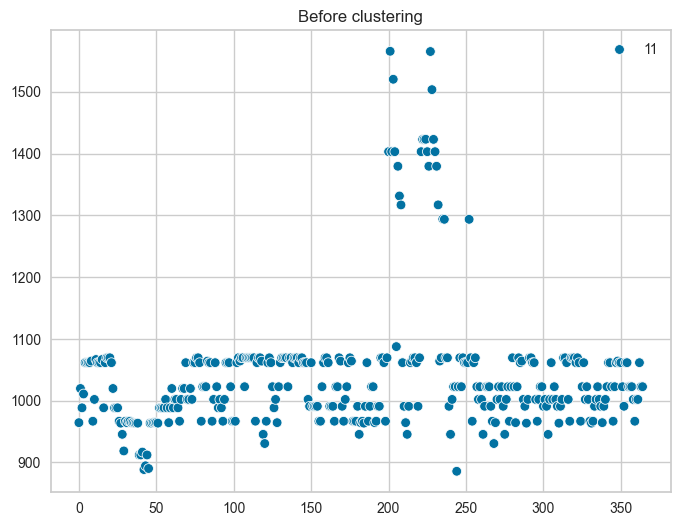

In [27]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(label="bla")
sns.scatterplot(df[feats], marker='o')
ax.set_title("Before clustering")

In [61]:
df['Clusters'].dtype

dtype('int64')

ValueError: 0      0
1      0
2      0
3      0
4      0
      ..
360    0
361    0
362    2
363    0
364    0
Name: Clusters, Length: 365, dtype: int64 is not a valid value for color

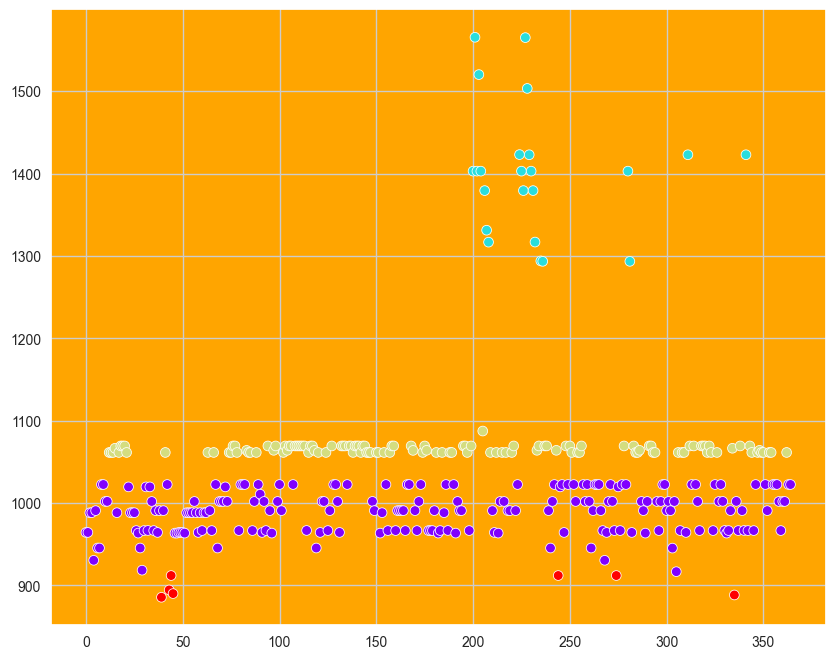

In [62]:
fig = plt.figure(figsize=(10,8))
sns.scatterplot(df[feats], c=df["Clusters"], marker='o',cmap="rainbow")
ax.set_title("After Clustering")

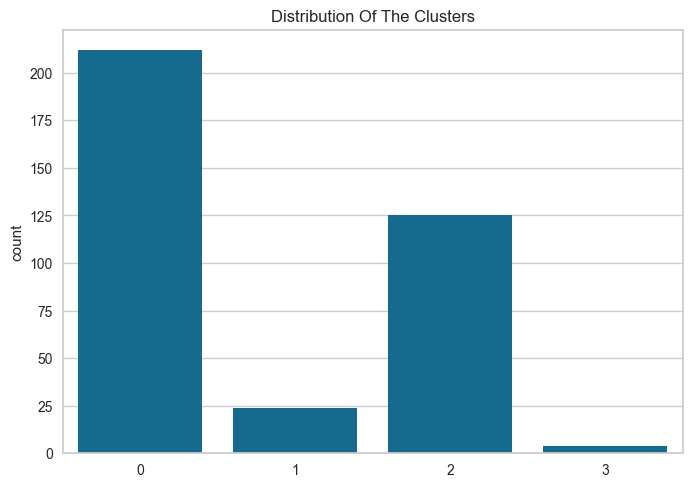

In [29]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

In [30]:
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [33]:
df['Day'] = pd.to_datetime(df['Day'], format='%d/%m/%Y')
df.sort_values(by='Day', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [35]:
test_size = df[df['Day'].dt.month==12].shape[0]
test_size

31

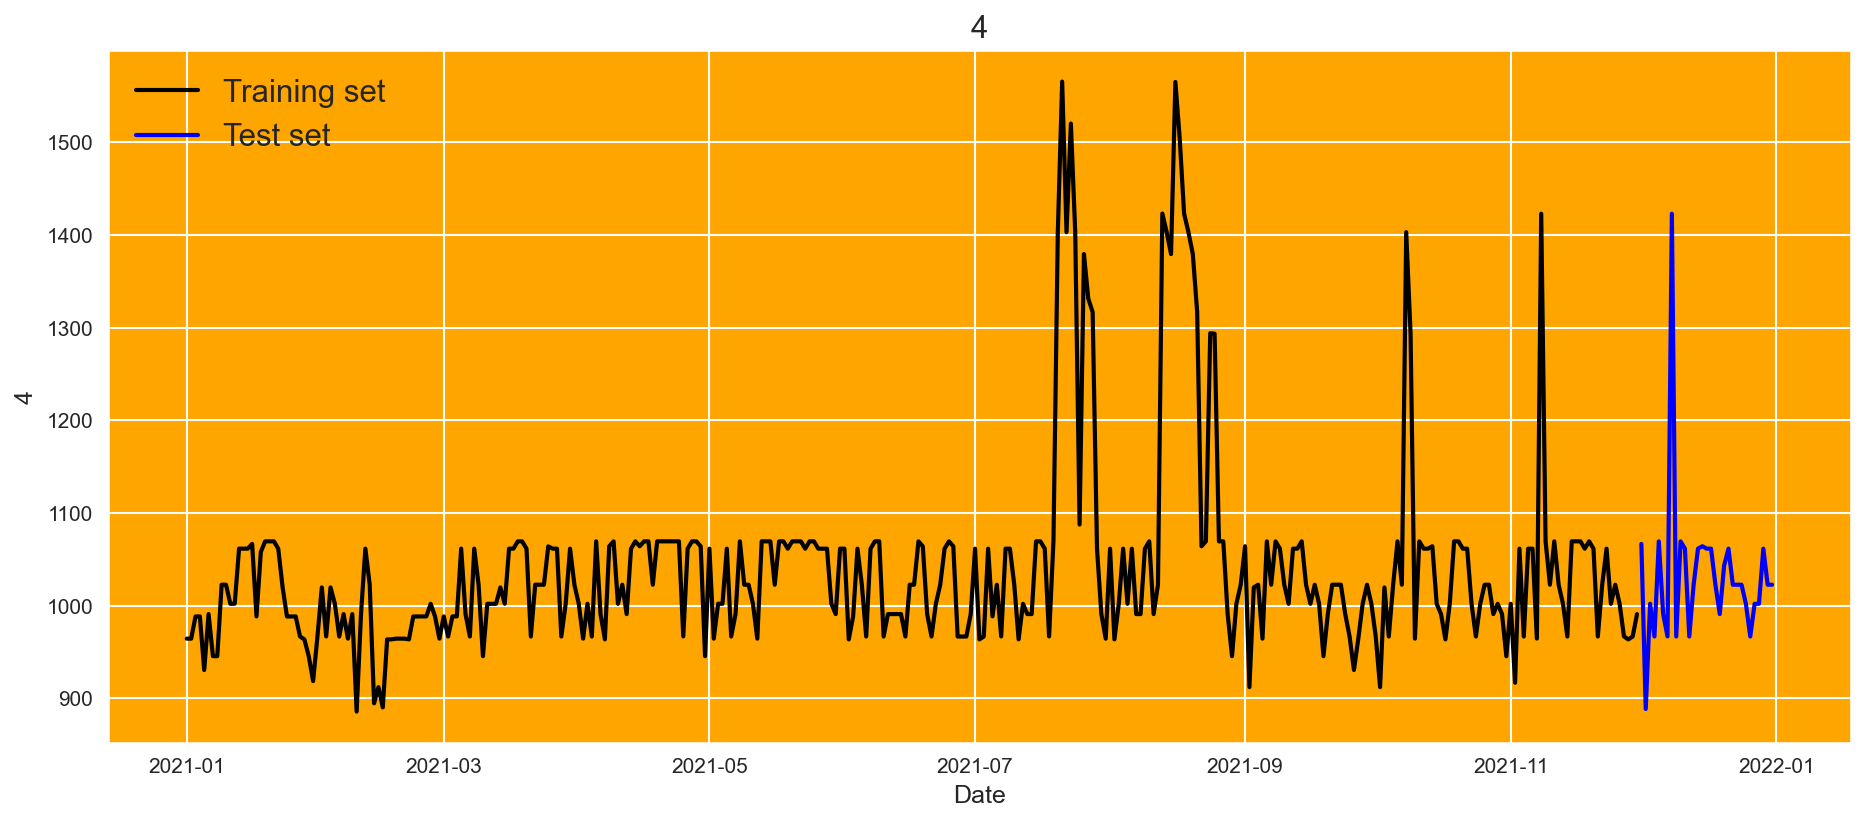

In [37]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'orange'
plt.rc('axes',edgecolor='white')
plt.plot(df['Day'][:-test_size], df['4'][:-test_size], color='black', lw=2)
plt.plot(df['Day'][-test_size:], df['4'][-test_size:], color='blue', lw=2)
plt.title('4', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('4', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [39]:
import plotly.express as px
fig = px.line(y=df['4'], x=df['Day'])
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Ngày",
                  yaxis_title="4",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(53,223,0,0.8)')

In [40]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df['4'].values.reshape(-1,1))

MinMaxScaler()

In [41]:
window_size = 15

In [42]:
train_data = df['4'][:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [43]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

In [44]:
test_data = df['4'][-test_size-window_size:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [45]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

In [46]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [47]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [48]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64)(input1)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

In [49]:
model = define_model()
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0549 - val_loss: 0.0220
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0303 - val_loss: 0.0161
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0347 - val_loss: 0.0154
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0253 - val_loss: 0.0160
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0266 - val_loss: 0.0161
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0238 - val_loss: 0.0156
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0196 - val_loss: 0.0156
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0217 - val_loss: 0.0168
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0238 - val_loss: 0.0158
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0237 - val_loss: 0.0161
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0261 - val_loss: 0.0184
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

In [51]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0201
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [52]:
from sklearn.metrics import mean_absolute_percentage_error,accuracy_score,r2_score
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1-MAPE

In [53]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.02014479599893093
Test MAPE: 1.9647321501072474
Test Accuracy: -0.9647321501072474


In [54]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

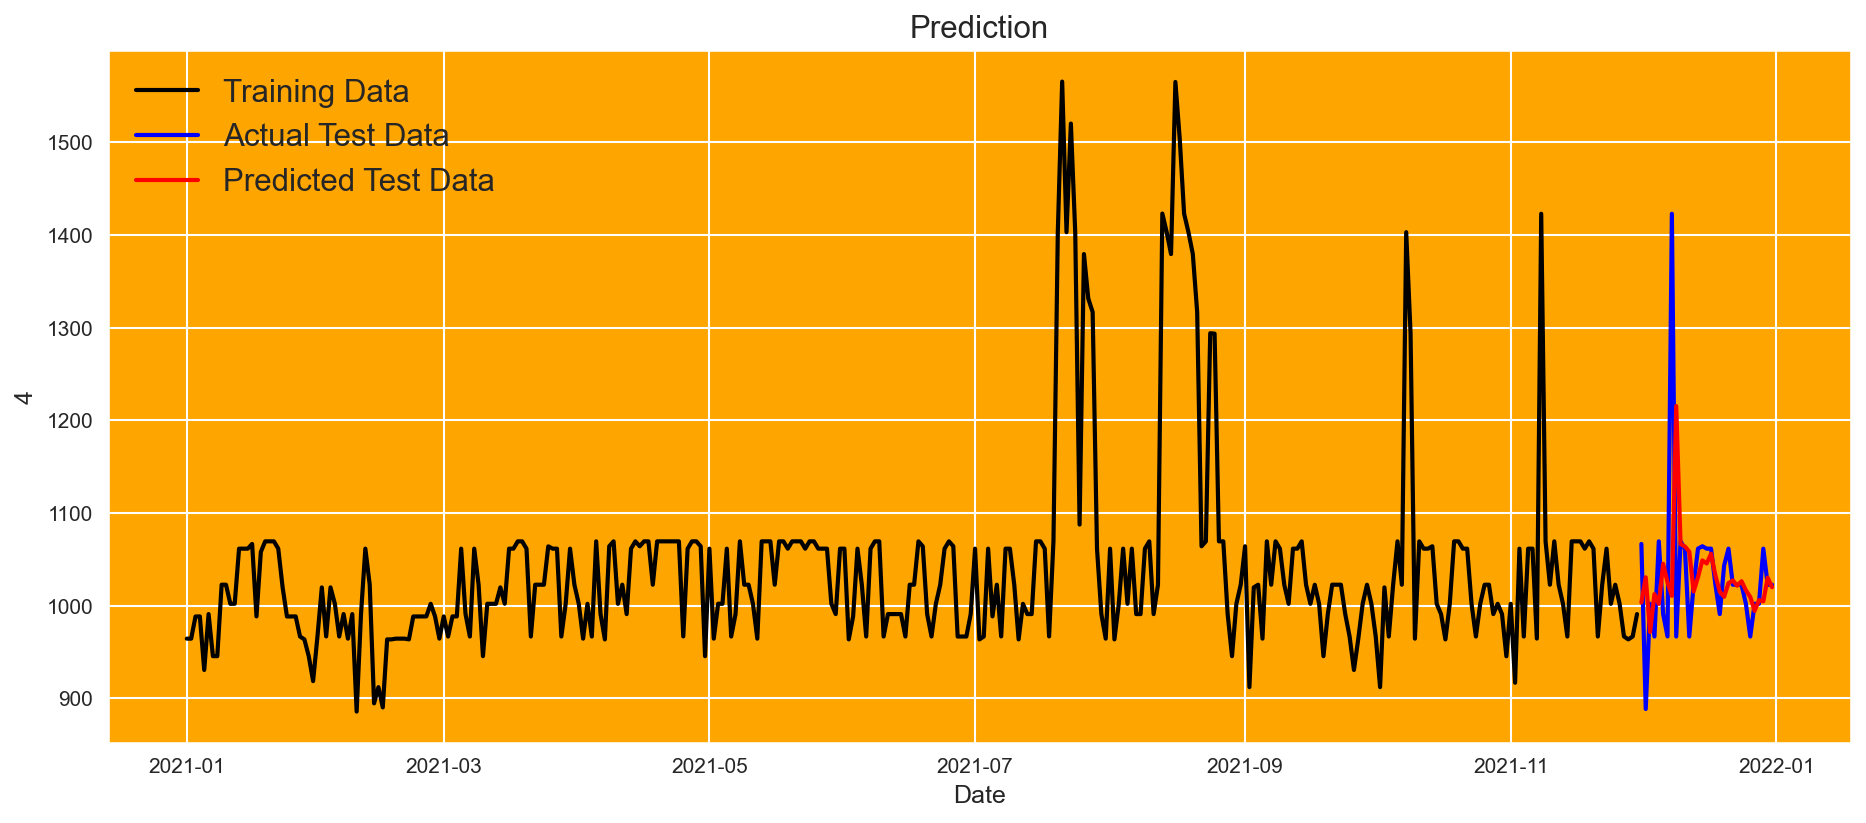

In [56]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'orange'
plt.rc('axes',edgecolor='white')
plt.plot(df['Day'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Day'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Day'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('4', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()